### 토픽모델링

#### 라이브러리 및 폰트 설치

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
!pip install konlpy
!pip install tomotopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 73.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 40.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 56.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import re
import tomotopy as tp
import os
from konlpy.tag import Okt
from konlpy.tag import Hannanum

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from sklearn.preprocessing import MinMaxScaler
import progressbar
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

plt.rc('font', family='NanumBarunGothic') 

#### 군집 분석

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Project/Machine Learning/Total_Excel.xlsx')

In [ ]:
df_high = df[df['Mix'] > 2.5]
df_low = df[df['Mix'] < 2.50001]

In [ ]:
def kmeans_topic(dataframe, num_cluster):
  okt = Okt()
  df = dataframe
  docs = []

  for i in df['Review_Text']:
      docs.append(okt.nouns(i))

  for i in range(len(docs)):
      docs[i] = ' '.join(docs[i])

  vec = CountVectorizer()
  X = vec.fit_transform(docs)

  temp_df = pd.DataFrame(X.toarray())
  kmeans = KMeans(n_clusters=num_cluster).fit(temp_df)

  pca = PCA(n_components=2)
  principalComponents = pca.fit_transform(df)
  principalDf = pd.DataFrame(data = principalComponents, columns = ['pricipal component 1', 'principal component 2'])

  plt.scatter(principalDf.iloc[kmeans.labels_ == 0,0], principalDf.iloc[kmeans.labels_ == 0,1], s=10, c='red', label='cluster1')
  plt.scatter(principalDf.iloc[kmeans.labels_ == 1,0], principalDf.iloc[kmeans.labels_ == 1,1], s=10, c='blue', label='cluster2')
  plt.scatter(principalDf.iloc[kmeans.labels_ == 2,0], principalDf.iloc[kmeans.labels_ == 2,1], s=10, c='green', label='cluster3')
  plt.legend()
  
  return plt.show()

In [ ]:
okt = Okt()
docs = []

for i in df_high['Review_Text']:
    docs.append(okt.nouns(i))

for i in range(len(docs)):
    docs[i] = ' '.join(docs[i])

In [ ]:
vec = CountVectorizer()
X = vec.fit_transform(docs)

temp_df = pd.DataFrame(X.toarray())
kmeans = KMeans(n_clusters=5).fit(temp_df)

In [ ]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pricipal component 1', 'principal component 2'])

plt.scatter(principalDf.iloc[kmeans.labels_ == 0,0], principalDf.iloc[kmeans.labels_ == 0,1], s=10, c='red', label='cluster1')
plt.scatter(principalDf.iloc[kmeans.labels_ == 1,0], principalDf.iloc[kmeans.labels_ == 1,1], s=10, c='blue', label='cluster2')
plt.scatter(principalDf.iloc[kmeans.labels_ == 2,0], principalDf.iloc[kmeans.labels_ == 2,1], s=10, c='green', label='cluster3')
plt.legend()

In [ ]:
kmeans_topic(df_high, 5)

#### LDA

In [ ]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import gensim
from nltk.tokenize import RegexpTokenizer
import konlpy
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
# 데이터 로드
df

In [ ]:
# konlpy의 okt를 이용하여 토크나이저 정의
# 가장 기본적인 전처리만 사용하여 정의함

def tokenizer(text):
    text = re.sub(r'[^,.?!\w\s]','', text)  # ,.?!와 문자+숫자+_(\w)와 공백(\s)만 남김  
    
    okt = konlpy.tag.Okt()
    Okt_morphs = okt.pos(text) # norm이랑 stem사용할지 안할지 고민 ...
    
    words = []
    for word, pos in Okt_morphs:
        if pos == 'Adjective' or pos == 'Verb' or pos == 'Noun':  # 이 경우에는 형용사, 동사, 명사만 남김
            words.append(word)

    words_str = ' '.join(words)
    return words_str

In [ ]:
tokenized_list = []
for text in df['Review_Text']:
    tokenized_list.append(tokenizer(text))

In [ ]:
# 전체 데이터로 tokenized_list 형성
tokenized_list = []
for text in df['Review_Text']:
    tokenized_list.append(tokenizer(text))

# 해당 corpus에서 너무 작은 corpus는 제거함
drop_corpus = []

for i in range(len(tokenized_list)):
    corpus = tokenized_list[i]
    if len(set(corpus.split())) < 3:   # 같은 단어 1-2개만 반복되는 corpus도 지우기 위해 set()을 사용
        df.drop(i, axis='index', inplace=True)
        drop_corpus.append(corpus)
    
for corpus in drop_corpus:
    tokenized_list.remove(corpus)

df.reset_index(drop=True, inplace=True)


In [ ]:
print(len(tokenized_list))
print(len(df))

In [ ]:
#LDA 는 Count기반의 Vectorizer만 적용 
count_vectorizer = CountVectorizer(max_df=0.1, max_features=1000, min_df=2, ngram_range=(1,2))
    # 2개의 문서 미만으로 등장하는 단어는 제외, 전체의 10% 이상으로 자주 등장하는 단어는 제외
    # bigram도 포함

feat_vect = count_vectorizer.fit_transform(tokenized_list)
print('CountVectorizer Shape:', feat_vect.shape)

In [ ]:
lda = LatentDirichletAllocation(n_components=10)  # 토픽 수는 6개로 설정
lda.fit(feat_vect)

In [ ]:
def display_topics(model, feature_names, num_top_words):
    for topic_index, topic in enumerate(model.components_):
        print('Topic #', topic_index)

        # components_ array에서 가장 값이 큰 순으로 정렬했을 때, 그 값의 array index를 반환. 
        topic_word_indexes = topic.argsort()[::-1]
        top_indexes=topic_word_indexes[:num_top_words]
        
        # top_indexes대상인 index별로 feature_names에 해당하는 word feature 추출 후 join으로 concat
        feature_concat = ' '.join([feature_names[i] for i in top_indexes])                
        print(feature_concat)

# CountVectorizer객체내의 전체 word들의 명칭을 get_features_names( )를 통해 추출
feature_names = count_vectorizer.get_feature_names()

# Topic별 가장 연관도가 높은 word를 10개만 추출
display_topics(lda, feature_names, 10)

In [ ]:
import pyLDAvis.sklearn  # sklearn의 ldamodel에 최적화된 라이브러리

pyLDAvis.enable_notebook()
vis = pyLDAvis.sklearn.prepare(lda, feat_vect, count_vectorizer)
pyLDAvis.display(vis)

#### Gensim-LDA

In [3]:
import konlpy
import re
import pandas as pd

In [4]:
df = pd.read_excel('/content/drive/MyDrive/Project/Machine Learning/Total_Excel.xlsx')
df_high = df[df['Mix'] > 2.5]
df_low = df[df['Mix'] < 2.50001]
df_high.reset_index(drop=True, inplace=True)
df_low.reset_index(drop=True, inplace=True)

In [5]:
def tokenize_korean_text(text):
    text = re.sub(r'[^,.?!\w\s]','', text)
    
    okt = konlpy.tag.Okt()
    Okt_morphs = okt.pos(text)
    
    words = []
    for word, pos in Okt_morphs:
        if pos == 'Adjective' or pos == 'Verb' or pos == 'Noun':
            words.append(word)
    ## word를 이어붙인 string 형태가 아닌 word의 list를 return해주는 게 sklearn lda 준비 과정과의 차이
            
    return words


tokenized_list = []

for text in df_low['Review_Text']:
    tokenized_list.append(tokenize_korean_text(text))

print(len(tokenized_list))
print(tokenized_list[1])

85545
['선물', '용', '받아서', '전달', '했어야', '하는', '상품', '이었는데', '머그컵', '와서', '당황', '했습니다', '전화했더니', '바로', '주신다', '했지만', '배송', '누락', '되어있었네요', '확인', '안', '바로', '선물', '했으면', '큰일', '날', '뻔했네요', '배송', '걸렸으면', '사는거', '다시', '생각', '했을거', '같아요', '아쉽네요']


In [ ]:
drop_corpus = []

for index in range(len(tokenized_list)):
    corpus = tokenized_list[index]
    if len(set(corpus)) < 3:   # corpus 자체가 list 형태인게 sklearn lda 준비 과정과의 차이
        df_low.drop(index, axis=0, inplace=True)
        drop_corpus.append(corpus)
    
for corpus in drop_corpus:
    tokenized_list.remove(corpus)

df_low.reset_index(drop=True, inplace=True)

In [7]:
# bigram 생성에 필요한 library
from gensim.models import Phrases
from gensim.models.phrases import Phraser

# vectorize & lda에 필요한 library
from gensim import corpora
from gensim.models.ldamodel import LdaModel

In [8]:
# Build the bigram models
bigram = Phrases(tokenized_list, min_count=4, threshold=10)
bigram_mod = Phraser(bigram)
 
# See example
print(bigram_mod[tokenized_list[0]])

['택배', '엉망', '용', '집', '밑', '층', '말', '놔두고가고']


In [9]:
# tokenized_list의 모든 문서에 대해 bigram을 생성해줌
words_bigram = [bigram_mod[doc] for doc in tokenized_list]

In [10]:
dictionary = corpora.Dictionary(words_bigram)  # 각 단어에 번호를 할당해줌
    # bigram 포함하는 과정을 생략하고 싶으면, 그냥 바로 여기에 tokenized_list를 넣어주면 됨

dictionary.filter_extremes(no_below=2, no_above=0.05)   
    # 2개의 문서 미만으로 등장하는 단어는 제외, 전체의 5% 이상으로 자주 등장하는 단어는 제외

corpus = [dictionary.doc2bow(text) for text in words_bigram]
print(corpus[0]) # 첫번째 corpus를 테스트로 출력: 몇 번째 단어가 몇 번 나왔는지 저장되어 있음

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]


In [11]:
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

In [12]:
coh_value = []
for i in range(2,15):
  ldamodel = LdaModel(corpus, num_topics=i, id2word=dictionary, passes=1, iterations=30)
  cm = CoherenceModel(model=ldamodel, texts=words_bigram, dictionary=dictionary, topn=10)
  coherence_lda = cm.get_coherence()
  coh_value.append(coherence_lda)

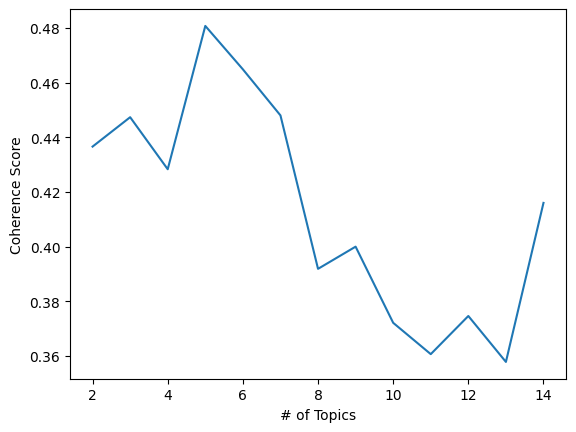

In [13]:
x = range(2,15)
plt.plot(x, coh_value)
plt.xlabel('# of Topics')
plt.ylabel('Coherence Score')
plt.show()

In [14]:
ldamodel = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=3, iterations=500)  # 토픽 수: 6

ldamodel.print_topics(num_words=20)  # num_words=10이 default

[(0,
  '0.011*"사용" + 0.007*"부분" + 0.006*"잘" + 0.005*"사이즈" + 0.005*"해서" + 0.004*"입니다" + 0.004*"조립" + 0.004*"더" + 0.003*"하나" + 0.003*"다시" + 0.003*"거" + 0.003*"합니다" + 0.003*"설치" + 0.003*"했는데" + 0.003*"못" + 0.003*"저" + 0.003*"구멍" + 0.003*"구매" + 0.003*"나사" + 0.003*"진짜"'),
 (1,
  '0.014*"상품" + 0.010*"개" + 0.008*"포장" + 0.008*"했는데" + 0.008*"불량" + 0.007*"반품" + 0.007*"박스" + 0.006*"교환" + 0.006*"물건" + 0.006*"왔어요" + 0.006*"해서" + 0.006*"왔네요" + 0.006*"주문" + 0.005*"하나" + 0.005*"재구매" + 0.004*"안" + 0.004*"사진" + 0.004*"구매" + 0.004*"택배" + 0.004*"주문_했는데"'),
 (2,
  '0.007*"맛" + 0.007*"냄새" + 0.007*"저" + 0.006*"가격" + 0.006*"샀는데" + 0.006*"진짜" + 0.005*"입니다" + 0.005*"그냥_그래요" + 0.005*"요" + 0.004*"재질" + 0.004*"옷" + 0.004*"넘" + 0.004*"사용" + 0.004*"같아요" + 0.004*"느낌" + 0.004*"정말" + 0.004*"거" + 0.004*"정도" + 0.004*"더" + 0.003*"향"'),
 (3,
  '0.009*"잘" + 0.006*"안" + 0.004*"뚜껑" + 0.004*"더" + 0.004*"부분" + 0.004*"때" + 0.004*"느낌" + 0.004*"유통_기한" + 0.004*"봐요" + 0.004*"좋아요" + 0.004*"조금" + 0.003*"손" + 0.003*"거" + 0.003*"하나" + 0

In [ ]:
!pip install pyLDAvis

In [ ]:
import pyLDAvis.gensim  # gensim의 ldamodel에 최적화된 라이브러리

vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis)